In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
from scipy import optimize
import scipy.special as ss
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm.notebook import tqdm
import os
#%config InlineBackend.figure_formats = ['svg']
plt.rcParams['mpl_toolkits.legacy_colorbar'] = False

# General functions

In [2]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],complex]:
    τ = np.arange(0, β+1e-10, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time_sing (β:float, iωn:np.array, Giωn_sing:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) ) + (-1/2 if τ>=0 else +1/2)
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn_sing )   + (-1/2 if τ>=0 else +1/2)
    return np.vectorize(f)

In [3]:
def Giωn_at (β, iωn, U):
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )

def Gτ_at (β, τ, U):
    return -1/2 * np.exp(-τ*U/2) / ( np.exp(-β*U/2) + 1 ) -1/2 * np.exp(+τ*U/2) / ( np.exp(+β*U/2) + 1 )

def G0_loc_iωn (latt_hilbert, iωn, µ):
    return latt_hilbert(iωn+µ)

In [14]:
def plot_Gτ_without_discont (Gτ_f, τ, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    pos = np.where(τ >= 0)[0][0]
    Gτ = np.insert(np.real(Gτ_f(τ)), pos, np.nan)
    τ = np.insert(τ, pos, np.nan)
    plt.plot(τ,Gτ,**kwargs)

In [4]:
# t = 1 implicitely here, for the Bethe lattice

def latt_Bethe_DoS (ϵ:float) -> float:
    return 1/(2*π) * np.sqrt(4-ϵ**2)

def latt_Bethe_hilbert (z:complex) -> complex:
    s = np.sign(np.imag(z))
    return ( z - 1j*s*np.sqrt(4 - z**2) ) /2

def latt_Bethe_R (η:complex) -> complex:
    if np.any(np.abs(η)>1):
        raise ValueError("the reciprocal Hilbert transform for the Bethe lattice is defined only on {|z|<1}")
    return η + 1/η

In [5]:
# eq (self-consistent-eq-reciproc-Hilbert-fromcavity)

def imp_Gbath_from_Gloc (R:Callable[[complex],complex], iωn:np.array, Gloc_iωn:np.array, µ:float) -> np.array:
    return 1 /( iωn + µ + 1/Gloc_iωn - R(Gloc_iωn) )

# IPT DMFT loop

In [6]:
def impurity_solver_IPT (β:float, U:float, iωn:np.array, Gbath_iωn:np.array, dτ=1e-3) -> Callable[[int],complex]:
    # Gbath_iωn should have an even size 2N, corresponding to n's in [-N,N[ (eg. [-1,0], [-2,-1,0,1]...)
    Gbath_shift_iωn = 1/( 1/Gbath_iωn - U/2 )
    τ = np.arange(0, β+1e-10, dτ)
    Gbath_shift_τ = greenmatsubara_freq_to_time_sing(β, iωn, Gbath_shift_iωn-1/iωn)
    Gbath_shift_τ = Gbath_shift_τ(τ)
                                   # between 0 and β integrate G(τ)^3 exp(i.ωn.τ)
    f = lambda n: U/2 + U**2 * dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gbath_shift_τ**3 )
    return np.vectorize(f)

In [ ]:
def plot_Giωn (ax, G_iωn, name="G", twinx_im=False):
    n = np.arange(-len(G_iωn)//2,len(G_iωn)//2)
    if twinx_im:
        ax_im = ax.twinx()
    else:
        ax_im = ax
    ax_im.plot(n, np.imag(G_iωn), '.--', lw=1, label='im. part', color='blue')
    ax.plot(n, np.real(G_iωn), '.--', lw=1, label='re. part', color='orange')
    ax.set_xlabel("$n$")
    ax.set_title("$"+name+r"(i\omega_n)$")
    ax.legend(loc='upper left')
    if twinx_im:
        ax_im.legend(loc='upper right')
        m = 1.5 * np.max(np.abs(np.real(G_iωn)))
        ax.set_ylim((-m,+m))

def DMFT_loop_Gloc (β, U, latt_R, Gloc_iωn_0, conv_thresh=1e-5, γ=0.9, callback=None):
    µ = U/2
    n = np.arange(-len(Gloc_iωn_0)//2,len(Gloc_iωn_0)//2)
    iωn = 1j*ωn(β,n)
    
    Gloc_iωn = Gloc_iωn_0

    for it in range(100):

        # DMFT loop
        Gbath_iωn = imp_Gbath_from_Gloc (latt_Bethe_R, iωn, Gloc_iωn, µ)
        Σloc_iωn = impurity_solver_IPT (β, U, iωn, Gbath_iωn)
        Σloc_iωn = Σloc_iωn(n)
        Gloc_iωn_new = latt_Bethe_hilbert( iωn + µ - Σloc_iωn )
        # or : Gloc_iωn_new = 1 / ( 1/Gbath_iωn - Σloc_iωn )

        norm1_diff = np.linalg.norm(Gloc_iωn-Gloc_iωn_new, ord=1)
        if callback is not None:
            callback(it,iωn,Σloc_iωn,Gloc_iωn_new,norm1_diff)
        if norm1_diff < conv_thresh:
            Gloc_iωn = Gloc_iωn_new
            break
        Gloc_iωn = (1-γ) * Gloc_iωn + γ * Gloc_iωn_new

    return µ, Gloc_iωn, Σloc_iωn, Gbath_iωn

### Example of bistability
(initial condition matters)

11.176455396735806
1.6727605908224956
0.6363054473497685
0.27151646473418367
0.12937471048250962
0.06347779932187972
0.03172954977060988
0.015994693018116346
0.00809841009118202
0.00410940716288949
0.00208759087091237
0.0010611052390090616
0.0005395069698910973
0.00027434652813154877
0.00013951931283508588
7.095545214716296e-05


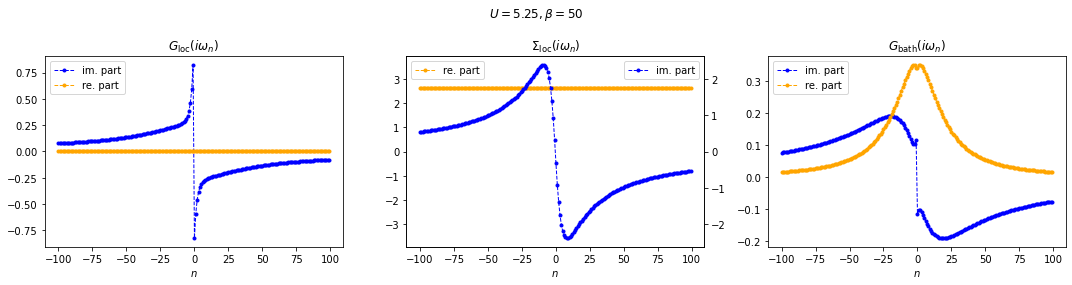

In [16]:
β = 50
U = 5.25
iωn = 1j*ωn(β,np.arange(-100,+100))
Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)     # metallic initial condition
#Gloc_iωn_0 = Giωn_at(β, iωn, U)        # atomic limit initial condition
def cb (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
    print(norm1_diff)
µ, Gloc_iωn, Σloc_iωn, Gbath_iωn = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=1.1, conv_thresh=1e-4, callback=cb)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}")
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True)
plot_Giωn(ax3, Gbath_iωn, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}$".format(U,β))
fig.tight_layout()

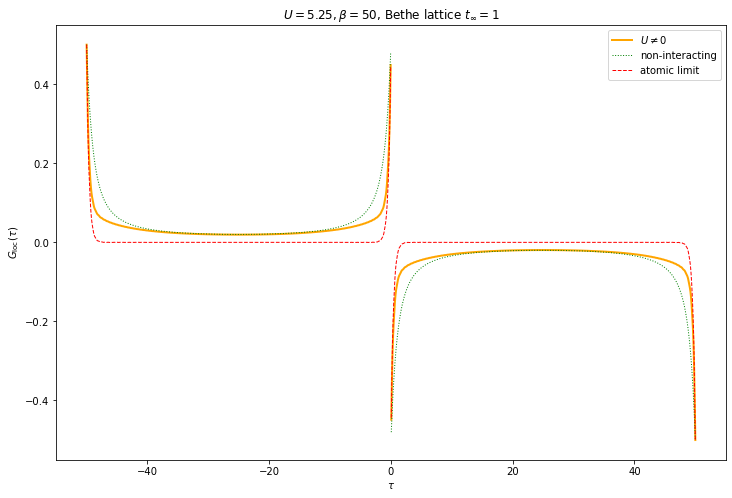

In [17]:
def plot_Gtau_compare (iωn, Gloc_iωn, latt_hilbert, β, U):

    plt.figure(figsize=(12,8))
    τ = np.linspace(-β,β,1000)

    Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Gloc_iωn-1/iωn)
    plot_Gτ_without_discont(Gloc_tau, τ, label=r"$U\neq 0$", color='orange', lw=2)

    Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, G0_loc_iωn(latt_hilbert, iωn, 0) -1/iωn)
    plot_Gτ_without_discont(Gloc_tau, τ, label=r"non-interacting", lw=1, linestyle='dotted', color="green")

    Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Giωn_at(β, iωn, U) -1/iωn)
    plot_Gτ_without_discont(Gloc_tau, τ, label=r"atomic limit", lw=1, linestyle='--', color="red")

    plt.title(r"$U={}, \beta={}$, Bethe lattice $t_\infty=1$".format(U,β))
    plt.ylabel(r"$G_\operatorname{loc}(\tau)$")
    plt.xlabel(r"$\tau$")
    plt.legend()

plot_Gtau_compare(iωn, Gloc_iωn, latt_Bethe_hilbert, β, U)

1.3298767512798502
0.4678902645595704
0.20718011060624977
0.10650850606468061
0.06060776687277204
0.037217482564665914
0.024201685202886493
0.016441271556417232
0.011556248815011494
0.00834536107071273
0.0061597424141675225
0.004628679439880129
0.003530250962977169
0.002726262437076271
0.0021277134082185387
0.0016756016729703796
0.0013298163610949085
0.0010624833447451208
0.0008538541256226939
0.0006896961406167891
0.0005595955351125337
0.00045582910507061675
0.00037259969157880934
0.0003055086441851561
0.00025118593418739857
0.00020702697185501565
0.00017100282158218766
0.00014152166166327487
0.00011732651227558052
9.741895740233639e-05


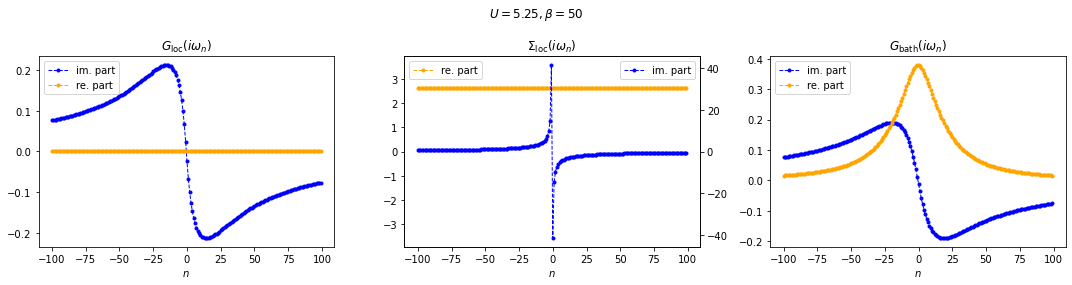

In [12]:
β = 50
U = 5.25
iωn = 1j*ωn(β,np.arange(-100,+100))
#Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)     # metallic initial condition
Gloc_iωn_0 = Giωn_at(β, iωn, U)        # atomic limit initial condition
def cb (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
    print(norm1_diff)
µ, Gloc_iωn, Σloc_iωn, Gbath_iωn = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4, callback=cb)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}")
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True)
plot_Giωn(ax3, Gbath_iωn, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}$".format(U,β))
fig.tight_layout()

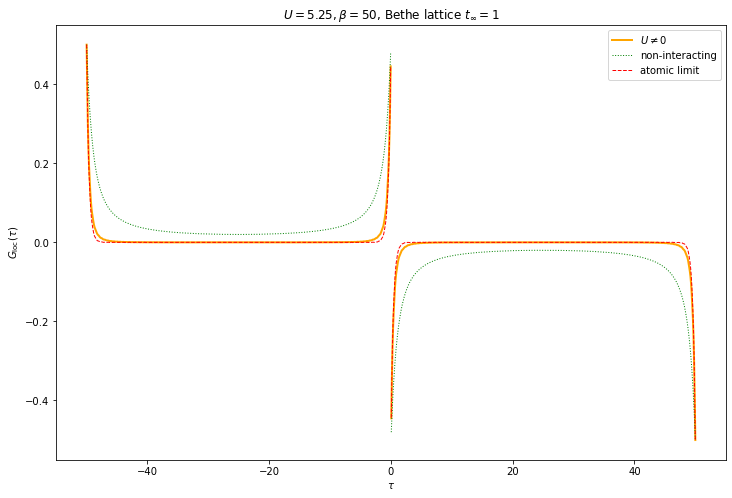

In [15]:
plot_Gtau_compare(iωn, Gloc_iωn, latt_Bethe_hilbert, β, U)

## Phase diagram based on quasi-particule weight

In [18]:
def quasipart_z (iωn, Σloc_iωn):
    n = len(iωn)//2
    deriv0 = (Σloc_iωn[n+1] - Σloc_iωn[n]).imag / (iωn[n+1] - iωn[n]).imag
    if deriv0 > 0:
        return np.nan
    else:
        return 1/(1-deriv0)

quasipart_z (iωn, Σloc_iωn)

0.17666716545643063

In [19]:
U_s = np.linspace(0,7,29)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_from_metal = np.zeros((len(β_s),len(U_s)))
ΣlocL2_from_metal = np.zeros((len(β_s),len(U_s)))

n = np.arange(-300,+300)
iωn = 1j*ωn(β,n)

for u,U in enumerate(U_s):
    for i,β in enumerate(β_s):
        filename = "data_bethe_from_metal/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
        else:
            Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Z_from_metal[i,u] = quasipart_z (iωn, Σloc_iωn)
        ΣlocL2_from_metal[i,u] = np.linalg.norm(np.imag(Σloc_iωn),ord=2)

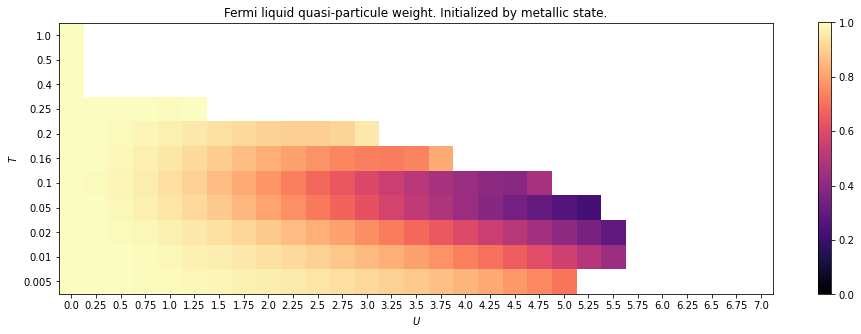

In [20]:
plt.figure(figsize=(16,5))
plt.imshow(Z_from_metal, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by metallic state.");

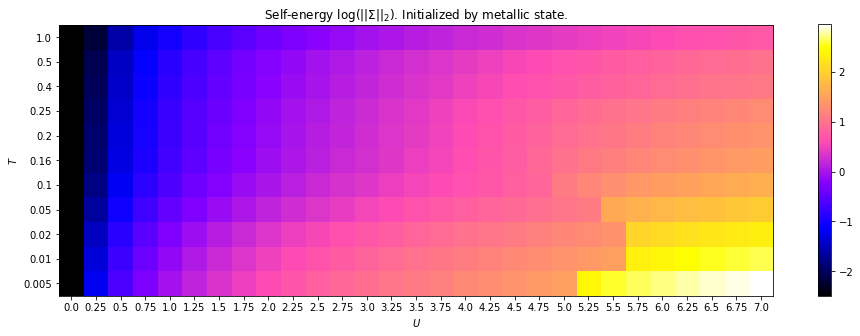

In [21]:
plt.figure(figsize=(16,5))
plt.imshow(np.log10(ΣlocL2_from_metal+1e-10), vmin=-2.5, cmap='gnuplot2', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title(r"Self-energy $\log(||\Sigma||_2)$. Initialized by metallic state.");

In [22]:
U_s = np.linspace(0.25,7,28)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_from_atomiclim = np.zeros((len(β_s),len(U_s)))

n = np.arange(-300,+300)
iωn = 1j*ωn(β,n)

for i,β in enumerate(β_s):
    for u,U in enumerate(U_s):
        filename = "data_bethe_from_atomiclim/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
        else:
            Gloc_iωn_0 = Giωn_at(β, iωn, U)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Z_from_atomiclim[i,u] = quasipart_z (iωn, Σloc_iωn)

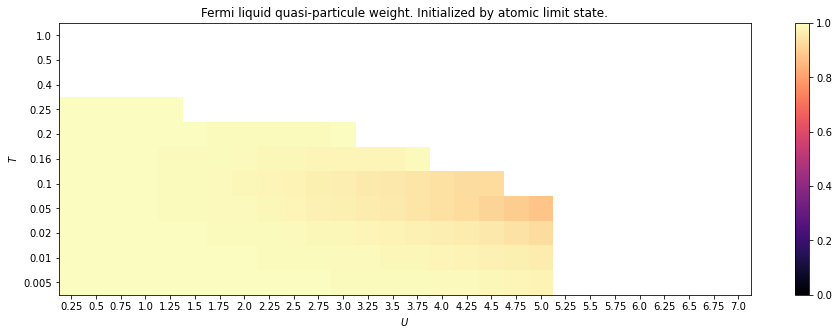

In [23]:
plt.figure(figsize=(16,5))
plt.imshow(Z_from_atomiclim, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by atomic limit state.");

In [24]:
U_s = np.linspace(0.25,7,28)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_increasingU = np.zeros((len(β_s),len(U_s)))

n = np.arange(-300,+300)
iωn = 1j*ωn(β,n)

for i,β in enumerate(β_s):
    Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
    for u,U in enumerate(U_s):
        filename = "data_bethe_increasingU/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
        else:
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Gloc_iωn_0 = np.copy(Gloc_iωn)
        Z_increasingU[i,u] = quasipart_z (iωn, Σloc_iωn)

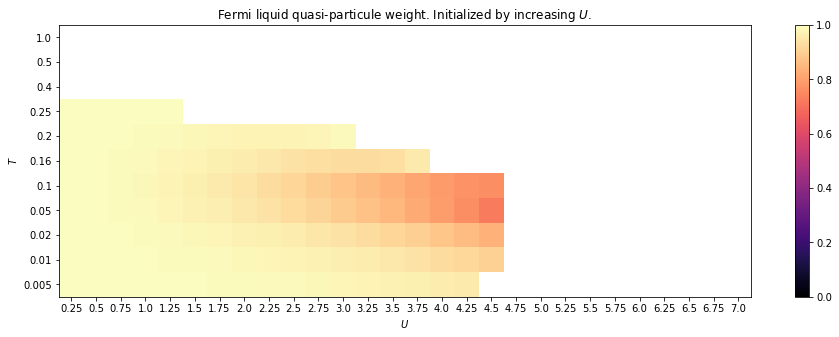

In [25]:
plt.figure(figsize=(16,5))
plt.imshow(Z_increasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by increasing $U$.");

In [26]:
U_s = np.flip(np.linspace(0.25,7,28))
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_decreasingU = np.zeros((len(β_s),len(U_s)))

n = np.arange(-300,+300)
iωn = 1j*ωn(β,n)

for i,β in enumerate(β_s):
    Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
    for u,U in enumerate(U_s):
        filename = "data_bethe_decreasingU/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
        else:
            print(β,U)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Gloc_iωn_0 = np.copy(Gloc_iωn)
        Z_decreasingU[i,u] = quasipart_z (iωn, Σloc_iωn)

U_s = np.flip(U_s)
Z_decreasingU = np.fliplr(Z_decreasingU)

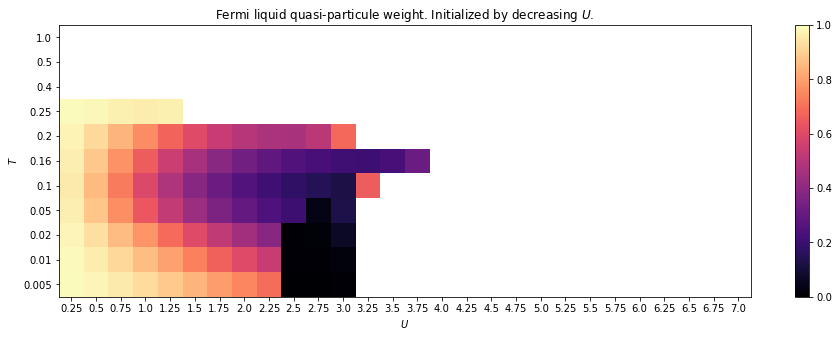

In [27]:
plt.figure(figsize=(16,5))
plt.imshow(Z_decreasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by decreasing $U$.");

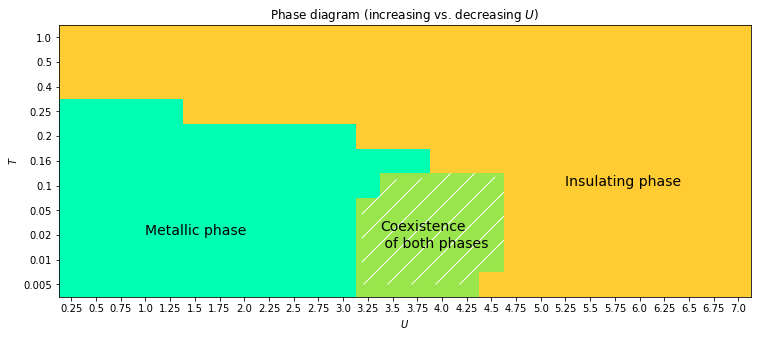

In [29]:
PhaseDiagram = np.where(~np.isnan(Z_increasingU), 0, 1)
PhaseDiagram = np.where(np.isnan(Z_decreasingU) & ~np.isnan(Z_increasingU), 2, PhaseDiagram)
#PhaseDiagram = np.where(PhaseDiagram==1 & )

plt.figure(figsize=(16,5))
plt.imshow(PhaseDiagram, origin='upper', cmap=mpl.colors.ListedColormap([(0,1,0.7),(1,0.8,0.2),(0.6,0.9,0.3)]))
X,Y = np.meshgrid(np.arange(len(U_s)),np.arange(len(β_s)))
cs = plt.contourf(X, Y, PhaseDiagram, hatches=['', '/'], extend='both', levels=[1.5,2.5])
for c in cs.collections:
    c.set_color('none') 
cs.collections[1].set_edgecolor('white')
cs.collections[1].set_linewidth(0)
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.text(3, 8, "Metallic phase", size=14)
plt.text(20, 6, "Insulating phase", size=14)
plt.text(12.5, 8.5, "Coexistence\n of both phases", size=14)
plt.title("Phase diagram (increasing vs. decreasing $U$)");